In [1]:
# https://pypi.tuna.tsinghua.edu.cn/simple
import anndata as ad
import scanpy as sc
import squidpy as sq
import cellcharter as cc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [51]:
rnadata = sc.read_h5ad("./RNA/spatial.combined.bin100.h5")
guide_genes = rnadata.var_names[~rnadata.var_names.str.startswith('sg')]
rnadata = rnadata[:, guide_genes].copy()

In [57]:
from bin import utils
rnadata = utils.remove_mito_ribo_hk_lnc_genes(rnadata).copy()
sc.pp.filter_cells(rnadata, min_counts=3)
sc.pp.filter_cells(rnadata, min_genes=3)
#rnadata.layers["counts"] = rnadata.X.copy()
#sc.pp.normalize_total(rnadata)
#sc.pp.log1p(rnadata)

In [60]:
import scvi

scvi.settings.seed = 114514
scvi.model.SCVI.setup_anndata(rnadata, batch_key="marker")
model=scvi.model.SCVI(rnadata, n_hidden=32, n_latent=10, n_layers=5, gene_likelihood="poisson", latent_distribution="normal")

model.train(early_stopping=True, enable_progress_bar=True)
model.save("/home/wpy/stereoseq/20240702-Exclusive/scvi.model", save_anndata=True, overwrite=True)

Global seed set to 114514
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(


Epoch 364/400:  91%|█████████ | 364/400 [18:30<01:49,  3.05s/it, loss=8.86e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 8890.663. Signaling Trainer to stop.


In [61]:
import scvi
model = scvi.model.SCVI.load("/home/wpy/stereoseq/20240702-Exclusive/scvi.model")

INFO     File /home/wpy/stereoseq/20240702-Exclusive/scvi.model/model.pt already downloaded                        


/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [62]:
rnadata.obsm["X_scVI"] = model.get_latent_representation(rnadata).astype(np.float32)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [63]:
rnadata.obs["marker"] = rnadata.obs["marker"].astype("category")

In [64]:
sq.gr.spatial_neighbors(rnadata, library_key="marker", coord_type="generic", delaunay=True, spatial_key="spatial")

In [65]:
cc.gr.remove_long_links(rnadata)

In [66]:
cc.gr.aggregate_neighbors(rnadata, n_layers=3, use_rep="X_scVI", out_key="X_cellcharter", sample_key="marker")

100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


In [67]:
autok = cc.tl.ClusterAutoK(
    n_clusters = (5,15),
    max_runs = 5,
    model_params = dict(
        random_state = 114514
    )
)

In [68]:
autok.fit(rnadata, use_rep="X_cellcharter")

Iteration 1/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:08,  1.42it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:01<00:06,  1.82it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 2/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:05,  2.26it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:05,  2.11it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 3/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:04,  2.47it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:04,  2.63it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 4/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:05,  2.11it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:04,  2.51it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 5/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:04,  2.50it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:04,  2.65it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

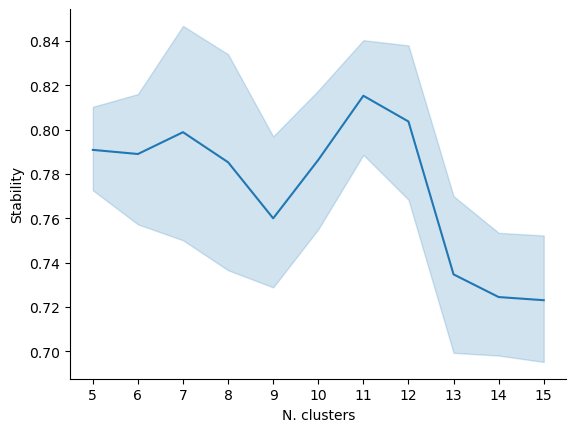

In [69]:
cc.pl.autok_stability(autok)

In [70]:
rnadata.obs["cluster"] = autok.predict(rnadata, use_rep="X_cellcharter")

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(


/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/ho

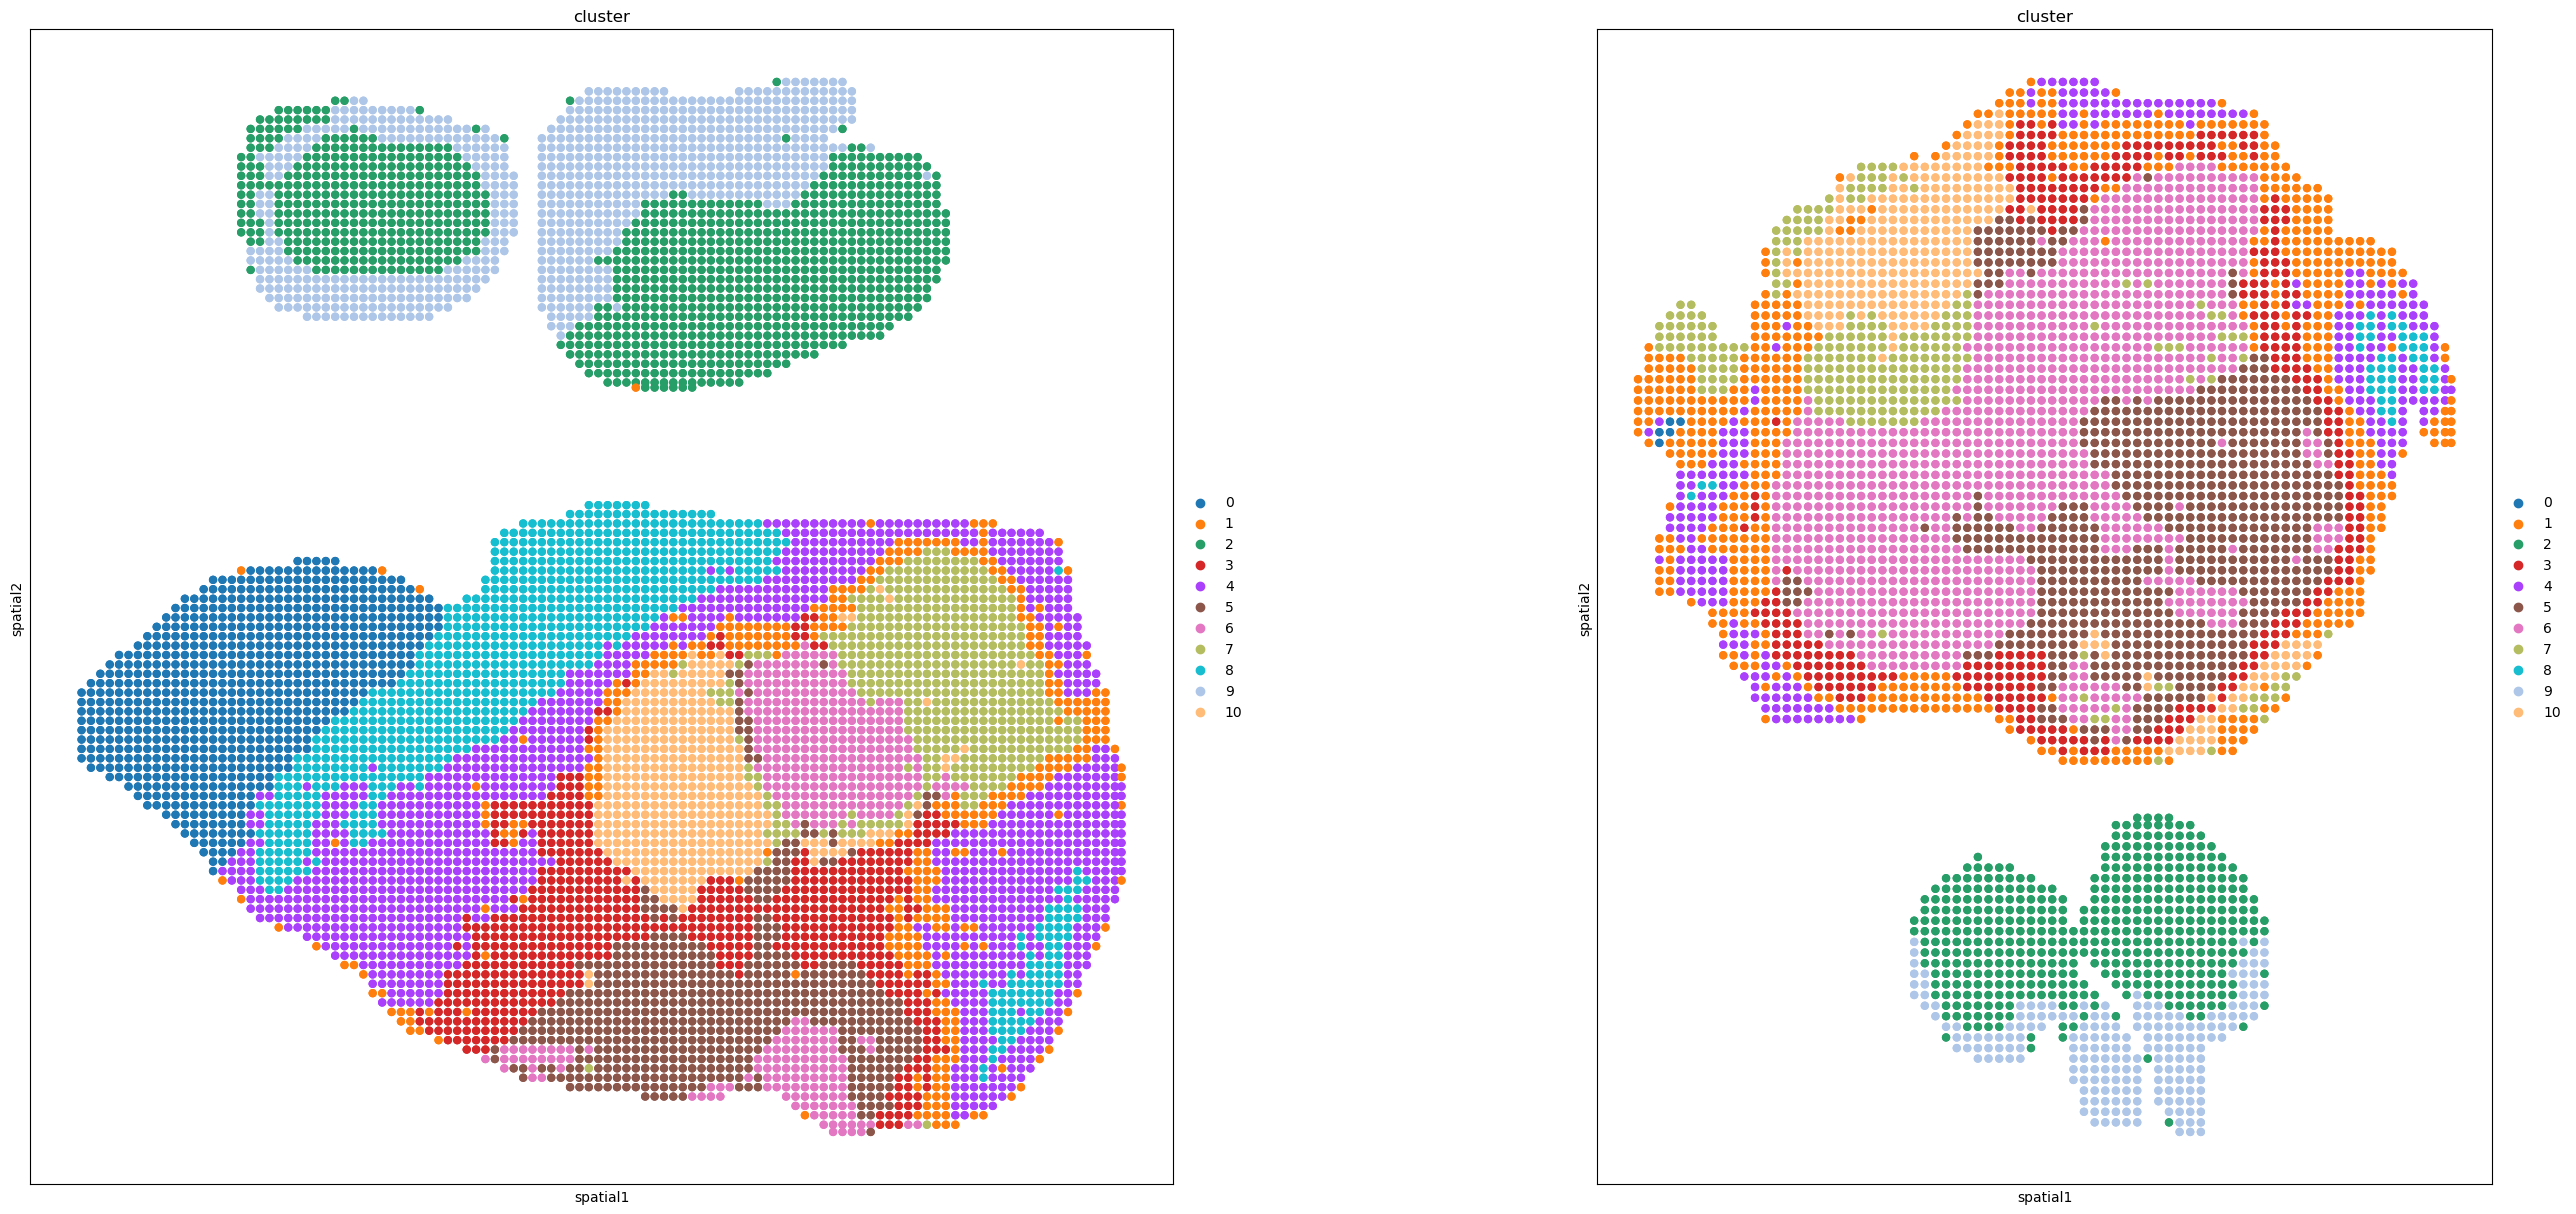

In [71]:
sq.pl.spatial_scatter(
    rnadata, 
    color=['cluster'], 
    library_key='marker',  
    size=100, 
    img=None,
    spatial_key='spatial',
    cmap='Set2',
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(15,15),
    ncols=2,
    shape=None
)

In [72]:
sc.pp.normalize_total(rnadata)
sc.pp.log1p(rnadata)

In [73]:
sc.tl.rank_genes_groups(rnadata, groupby="cluster", method='t-test')

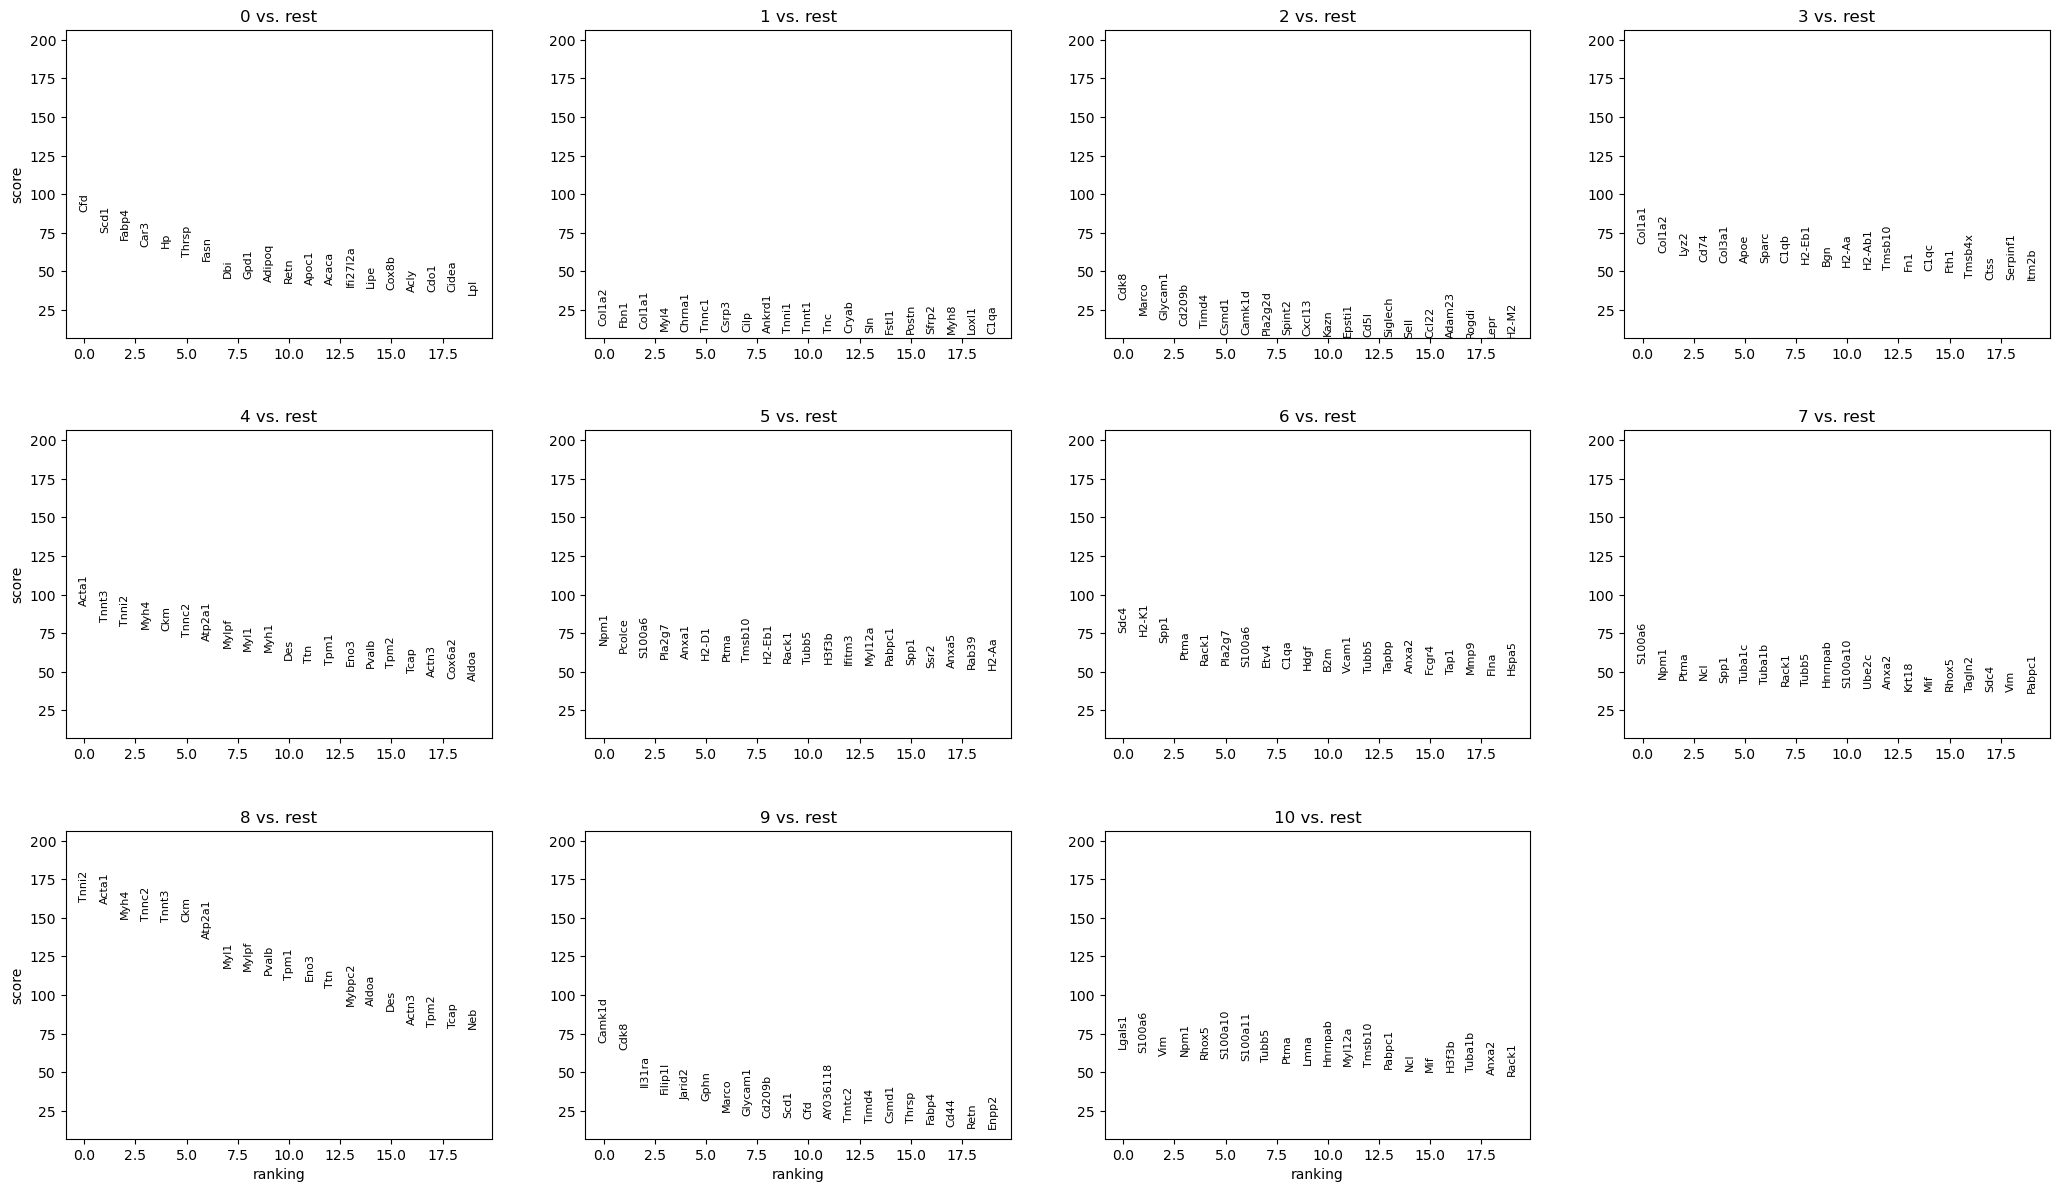

In [74]:
sc.pl.rank_genes_groups(rnadata, n_genes=20)

In [75]:
rnadata.write_h5ad("./RNA/spatial.combined.clustered.h5")

In [76]:
pval_cutoff = 0.01
top_n = 50

result = rnadata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < 0.01]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('DEG.csv', index=False, sep="\t")
top_genes_df

,Gene,Log2FoldChange,padj,score,Cluster
0,Cfd,6.215706,0.000000e+00,89.032761,0
1,Scd1,4.790031,0.000000e+00,75.151718,0
2,Fabp4,5.051640,0.000000e+00,70.500984,0
3,Car3,4.735151,0.000000e+00,65.914482,0
4,Hp,5.722812,3.451379e-307,65.229111,0
...,...,...,...,...,...
545,Gpx1,1.025088,1.856639e-250,40.112743,10
546,Pcbp1,1.432793,7.006092e-207,39.728298,10
547,Anxa5,1.171778,6.529299e-224,39.623924,10
548,Anxa1,1.579120,3.506380e-200,39.304073,10
